In [1]:
import sys
sys.path.append('./')
sys.path.append('/Users/olivierdedecker/Documents/00_Dev/Python/Discord_signals_backtester')
from helpers.backtest_tools.utilities.data_manager import ExchangeDataManager

from helpers.backtest_tools.utilities.backtesting_2 import Backtesting
from helpers.backtest_tools.utilities.custom_indicators_2 import CustomIndocators as ci
import pandas as pd
import pandas_ta as pda
import ta
import ccxt
import json

/Users/olivierdedecker/Documents/00_Dev/Python/Crypto_Robot_live/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#f = open('../database/pair_list.json',)
#pairJson = json.load(f)
#f.close()

In [3]:
exchange_name = "binance"

intervals = ["1h"]

#coin_to_dl = ['BTC/USDT', 'ETH/USDT', 'BNB/USDT', 'XRP/USDT', 'DOGE/USDT', 'ADA/USDT', 'MATIC/USDT', 'DOT/USDT', 'SHIB/USDT', 'LTC/USDT', 'TRX/USDT', 'SOL/USDT', 'AVAX/USDT', 'LINK/USDT', 'ATOM/USDT', 'ETC/USDT', 'BCH/USDT', 'FIL/USDT', 'APE/USDT', 'VET/USDT', 'EGLD/USDT', 'EOS/USDT', 'SAND/USDT', 'CHZ/USDT', 'AAVE/USDT', 'AXS/USDT', 'MANA/USDT', 'CAKE/USDT', 'FTM/USDT', 'MKR/USDT', 'GRT/USDT']
coin_to_dl = ['VET/USDT']

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="/Users/olivierdedecker/Documents/00_Dev/Python/Crypto_Robot_live/my_data//database/exchanges"
)

await exchange.download_data(
    coins=coin_to_dl, 
    intervals=intervals
)

	Récupération pour la paire VET/USDT en timeframe 1h sur l'exchange binance...
	Données déjà récupérées


/Users/olivierdedecker/Documents/00_Dev/Python/Discord_signals_backtester/helpers/backtest_tools/utilities/data_manager.py:237: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_name, index_col=0, parse_dates=True)


In [4]:
exchange_name = "binance"

exchange = ExchangeDataManager(
    exchange_name=exchange_name, 
    path_download="/Users/olivierdedecker/Documents/00_Dev/Python/Crypto_Robot_live/my_data//database/exchanges"
)

exchange.load_data(coin="BTC/USDT", interval="1h")

dfList = []
for pair in coin_to_dl:
    df = exchange.load_data(coin=pair, interval="1h")
    dfList.append(df)

print("Data load 100%")

Data load 100%


/Users/olivierdedecker/Documents/00_Dev/Python/Discord_signals_backtester/helpers/backtest_tools/utilities/data_manager.py:114: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_name, index_col=0, parse_dates=True)
/Users/olivierdedecker/Documents/00_Dev/Python/Discord_signals_backtester/helpers/backtest_tools/utilities/data_manager.py:114: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(file_name, index_col=0, parse_dates=True)


In [27]:
# -- Indicator variable --
aoParam1 = 10   #6
aoParam2 = 22   #24
stochWindow = 14
willWindow = 14
atrWindow = 10
chopWindow = 14
ST_length = 14
ST_multiplier = 3.5

multi = [0.05, 0.1, 0.15]

# -- Drop all columns we do not need --
for df in dfList:
    # -- Drop all columns we do not need --
    #df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

    # -- Indicators, you can edit every value --
    df['SMA0'] = ta.trend.ema_indicator(close=df['close'], window=5)
    df['SMA1'] = df.apply(lambda df: df.SMA0 * (1 + multi[0]), axis=1)
    df['SMA2'] = df.apply(lambda df: df.SMA0 * (1 + multi[1]), axis=1)
    df['SMA3'] = df.apply(lambda df: df.SMA0 * (1 + multi[2]), axis=1)
    df['SMA_1'] = df.apply(lambda df: df.SMA0 * (1 - multi[0]), axis=1)
    df['SMA_2'] = df.apply(lambda df: df.SMA0 * (1 - multi[1]), axis=1)
    df['SMA_3'] = df.apply(lambda df: df.SMA0 * (1 - multi[2]), axis=1)

print("Indicators loaded 100%")

Indicators loaded 100%


In [28]:
dfTestList = []
for df in dfList:
    dfTestList.append(df.loc['2021-01-01':])

In [29]:
# -- Starting value --
startingBalance = 1000
makerFee = 0.0002*0.9
takerFee = 0.0002*0.9

# -- Rules --
StopLossActivation = True
takeProfitActivation = False
showLog = True

# -- Hyper parameters --
SlPct = 0.9
#TpPct = 0.10

multiATR = 0.3

maxPositions = 3
nLevel = 3

leverage = 1

In [30]:
# -- Trade Functions --

# -- Condition to BUY market --
def openLongCondition(row, previousRow=None, openLong=0):
    sma = previousRow[f'SMA_{openLong+1}']
    if (
        row['low'] <= sma
    ):
        return sma
    else:
        return 0

# -- Condition to SELL market --
def closeLongCondition(row, previousRow=None, prePreviousRow=None):
    sma = prePreviousRow['SMA0']
    if (
        previousRow['close'] >= sma
        or previousRow['high'] >= sma
    ):
        return sma
    else:
        return 0

def openShortCondition(row, previousRow=None, openShort=0):
    sma = previousRow[f'SMA{openShort+1}']
    if (
        row['high'] >= sma
    ):
        return sma
    else:
        return 0

# -- Condition to SELL market --
def closeShortCondition(row, previousRow=None, prePreviousRow=None):
    sma = prePreviousRow['SMA0']
    if (
        previousRow['close'] <= sma
        or previousRow['low'] <= sma
    ):
        return sma
    else:
        return 0

In [31]:
# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
stopLoss = [0] * len(coin_to_dl)
takeProfit = [5000000] * len(coin_to_dl)
walletCoinArray = [0] * len(coin_to_dl)
walletUsdArray = [0] * len(coin_to_dl)
entryPrice = [0] * len(coin_to_dl)
leverageEnter = [1] * len(coin_to_dl)
position = ['LONG'] * len(coin_to_dl)
nPosition = [0] * len(coin_to_dl)
activePositions = 0
lastIndex = dfTestList[0].index.values[1]
lastLastIndex = dfTestList[0].index.values[1]

In [32]:
# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'symbol','position', 'reason',
                                 'price', 'frais', 'fiat', 'coins', 'wallet'])

In [33]:
for index, row in dfTestList[0].iterrows():
    # -- Check if you have one coin in your wallet --
    if (walletCoinArray.count(0) == len(walletCoinArray)) == False:
        # -- Iteration on all coin (upgrade possible: only check coin in your wallet) --
        for i in range(0,len(dfTestList)):
            leverageLong = 1
            leverageShort = 1
            # -- Check if you have more than 0 coin --
            if walletCoinArray[i] != 0:
                try:
                    actualRow = dfTestList[i].loc[index]
                    previousRow = dfTestList[i].loc[lastIndex]
                    prePreviousRow = dfTestList[i].loc[lastLastIndex]

                    # -- Take Profit Long --
                    if (actualRow['high'] > takeProfit[i] and position[i]=='LONG' and takeProfitActivation==True):
                        nPosition[i] = 0
                        sellPrice = takeProfit[i]
                        usd = usd + walletCoinArray[i] * entryPrice[i] / leverageEnter[i] + walletCoinArray[i] * (sellPrice - entryPrice[i])
                        fee = makerFee * walletCoinArray[i] * sellPrice
                        usd = usd - fee
                        # -- Set coin and equivalent usd to 0 after sold position --
                        walletCoinArray[i] = 0
                        walletUsdArray[i] = 0
                        activePositions -= 1

                        # -- LOG --
                        if showLog:
                            print("Sell COIN at Take Profit", sellPrice, '$ the', index)

                        # -- Add the trade to dfTrades to analyse it later --
                        myrow = {
                            'date': index,
                            'symbol': coin_to_dl[i],
                            'position': "Sell",
                            'reason': 'Sell Take Profit',
                            'price': sellPrice,
                            'frais': fee,
                            'fiat': usd,
                            'coins': 0,
                            'wallet': sum(walletUsdArray) + usd
                        }
                        dfTrades = dfTrades._append(myrow, ignore_index=True)

                    # -- Take Profit Short --
                    elif (actualRow['low'] < takeProfit[i] and position[i]=='SHORT' and takeProfitActivation==True):
                        nPosition[i] = 0
                        sellPrice = takeProfit[i]
                        usd = usd + walletCoinArray[i] * entryPrice[i] / leverageEnter[i] + walletCoinArray[i] * (entryPrice[i] - sellPrice)
                        fee = makerFee * walletCoinArray[i] * sellPrice
                        usd = usd - fee
                        # -- Set coin and equivalent usd to 0 after sold position --
                        walletCoinArray[i] = 0
                        walletUsdArray[i] = 0
                        activePositions -= 1

                        # -- LOG --
                        if showLog:
                            print("Sell COIN at Take Profit", sellPrice, '$ the', index)

                        # -- Add the trade to dfTrades to analyse it later --
                        myrow = {
                            'date': index,
                            'symbol': coin_to_dl[i],
                            'position': "Sell",
                            'reason': 'Sell Take Profit',
                            'price': sellPrice,
                            'frais': fee,
                            'fiat': usd,
                            'coins': 0,
                            'wallet': sum(walletUsdArray) + usd
                        }
                        dfTrades = dfTrades._append(myrow, ignore_index=True)

                    # -- Sell Market --
                    elif (closeLongCondition(actualRow,previousRow, prePreviousRow) != 0 and position[i] == 'LONG'):
                        nPosition[i] = 0
                        sellPrice = closeLongCondition(actualRow,previousRow, prePreviousRow)
                        usd = usd + walletCoinArray[i] * entryPrice[i] / leverageEnter[i] + walletCoinArray[i] * (sellPrice - entryPrice[i])
                        fee = makerFee * walletCoinArray[i] * sellPrice
                        usd = usd - fee
                        # -- Set coin and equivalent usd to 0 after sold position --
                        walletCoinArray[i] = 0
                        walletUsdArray[i] = 0
                        activePositions -= 1

                        # -- LOG --
                        if showLog:
                            print("Sell", coin_to_dl[i],"at", sellPrice, '$ the', index)

                        # -- Add the trade to DfTrades to analyse it later --
                        myrow = {
                            'date': index,
                            'symbol': coin_to_dl[i],
                            'position': "Close Long",
                            'reason': 'Sell Market Order',
                            'price': sellPrice,
                            'frais': fee,
                            'fiat': usd,
                            'coins': 0,
                            'wallet': sum(walletUsdArray) + usd
                        }
                        dfTrades = dfTrades._append(myrow, ignore_index=True)

                    # -- Sell Market --
                    elif (closeShortCondition(actualRow,previousRow,prePreviousRow) != 0 and position[i] == 'SHORT'):
                        nPosition[i] = 0
                        sellPrice = closeShortCondition(actualRow,previousRow,prePreviousRow)
                        usd = usd + walletCoinArray[i] * entryPrice[i] / leverageEnter[i] + walletCoinArray[i] * (entryPrice[i] - sellPrice)
                        fee = makerFee * walletCoinArray[i] * sellPrice
                        usd = usd - fee
                        # -- Set coin and equivalent usd to 0 after sold position --
                        walletCoinArray[i] = 0
                        walletUsdArray[i] = 0
                        activePositions -= 1

                        # -- LOG --
                        if showLog:
                            print("Sell", coin_to_dl[i],"at", sellPrice, '$ the', index)

                        # -- Add the trade to DfTrades to analyse it later --
                        myrow = {
                            'date': index,
                            'symbol': coin_to_dl[i],
                            'position': "Close Short",
                            'reason': 'Sell Market Order',
                            'price': sellPrice,
                            'frais': fee,
                            'fiat': usd,
                            'coins': 0,
                            'wallet': sum(walletUsdArray) + usd
                        }
                        dfTrades = dfTrades._append(myrow, ignore_index=True)


                except Exception as e:
                    error = f"{type(e).__name__} at line {e.__traceback__.tb_lineno}: {e}"
    # -- Buy market order --
    # -- Check if you can open a new position --
    if activePositions < maxPositions:
        # -- Check buy condition for each coin of list --
        for i in range(0,len(dfTestList)):
            try:
                actualRow = dfTestList[i].loc[index]
                previousRow = dfTestList[i].loc[lastIndex]
                leverageLong = 1
                leverageShort = 1
                # -- Buy condition --
                buyPrice = openLongCondition(actualRow, previousRow)
                if (buyPrice != 0 and ((activePositions < maxPositions and nPosition[i] == 0) 
                             or (nPosition[i] != 0 and nPosition[i] < nLevel))):
                    #buyPrice = actualRow['close']
                    # -- Define size of the position --
                    usdMultiplier = 1/nLevel * 1/(maxPositions-activePositions) * leverageLong
                    fee = takerFee * usd * usdMultiplier
                    usd = usd - fee
                    coin = (usd * usdMultiplier) / buyPrice
                    usd = usd - (usd * usdMultiplier / leverageLong)
                    leverageEnter[i] = leverageLong
                    entryPrice[i] = (buyPrice + entryPrice[i]*nPosition[i])/(nPosition[i]+1)
                    position[i] = 'LONG'
                    # -- Set coin and equivalent usd to size of position after open position --
                    walletCoinArray[i] += coin
                    walletUsdArray[i] += coin * actualRow['close'] / leverageLong
                    if nPosition[i] == 0:
                        activePositions += 1
                    nPosition[i] += 1
                    # -- Create a Stop Loss --
                    if StopLossActivation:
                        stopLoss[i] = buyPrice - SlPct * buyPrice
                    # -- Create a Take Profit --
                    if takeProfitActivation:
                        TpPct = actualRow['ATR']*multiATR
                        takeProfit[i] = buyPrice + TpPct
                    # -- LOG --
                    if showLog:
                        print("Buy", coin_to_dl[i],"at", buyPrice, '$ the', index)

                    # -- Add the trade to dfTrades to analyse it later --
                    myrow = {
                        'date': index,
                        'symbol': coin_to_dl[i],
                        'position': "Enter Long",
                        'reason': 'Buy Market Order',
                        'price': buyPrice,
                        'frais': fee,
                        'fiat': usd,
                        'coins': coin,
                        'wallet': sum(walletUsdArray) + usd
                    }
                    dfTrades = dfTrades._append(myrow, ignore_index=True)

                elif(openShortCondition(actualRow, previousRow) != 0 
                        and ((activePositions < maxPositions and nPosition[i] == 0) 
                             or (nPosition[i] != 0 and nPosition[i] < nLevel))):
                    buyPrice = openShortCondition(actualRow, previousRow)
                    # -- Define size of the position --
                    usdMultiplier = 1/nLevel * 1/(maxPositions-activePositions) * leverageShort
                    fee = takerFee * usd * usdMultiplier
                    usd = usd - fee
                    coin = (usd * usdMultiplier) / buyPrice
                    usd = usd - (usd * usdMultiplier / leverageShort)
                    leverageEnter[i] = leverageShort
                    entryPrice[i] = (buyPrice + entryPrice[i]*nPosition[i])/(nPosition[i]+1)
                    position[i] = 'SHORT'
                    # -- Set coin and equivalent usd to size of position after open position --
                    walletCoinArray[i] += coin
                    walletUsdArray[i] += coin * actualRow['close'] / leverageShort
                    if nPosition[i] == 0:
                        activePositions += 1
                    nPosition[i] += 1
                    # -- Create a Stop Loss --
                    if StopLossActivation:
                        stopLoss[i] = buyPrice + SlPct * buyPrice
                    # -- Create a Take Profit --
                    if takeProfitActivation:
                        TpPct = actualRow['ATR']*multiATR
                        takeProfit[i] = buyPrice - TpPct

                    # -- LOG --
                    if showLog:
                        print("Buy", coin_to_dl[i],"at", buyPrice, '$ the', index)

                    # -- Add the trade to dfTrades to analyse it later --
                    myrow = {
                        'date': index,
                        'symbol': coin_to_dl[i],
                        'position': "Enter Short",
                        'reason': 'Buy Market Order',
                        'price': buyPrice,
                        'frais': fee,
                        'fiat': usd,
                        'coins': coin,
                        'wallet': sum(walletUsdArray) + usd
                    }
                    dfTrades = dfTrades._append(myrow, ignore_index=True)
            except Exception as e:
                error = f"{type(e).__name__} at line {e.__traceback__.tb_lineno}: {e}"

    # -- Keep last index to define last row --  
    lastLastIndex = lastIndex          
    lastIndex = index

print("Final wallet", sum(walletUsdArray) + usd)

Buy VET/USDT at 0.019795977293621203 $ the 2021-01-01 01:00:00
Buy VET/USDT at 0.02012906819574747 $ the 2021-01-01 02:00:00
Sell VET/USDT at 0.019583020471863135 $ the 2021-01-01 07:00:00
Buy VET/USDT at 0.01858691555226284 $ the 2021-01-01 18:00:00
Sell VET/USDT at 0.01920453311571551 $ the 2021-01-01 22:00:00
Buy VET/USDT at 0.02037913541363453 $ the 2021-01-02 17:00:00
Buy VET/USDT at 0.020955340275756355 $ the 2021-01-02 18:00:00
Buy VET/USDT at 0.0192702082590343 $ the 2021-01-02 20:00:00
Sell VET/USDT at 0.020284429746351897 $ the 2021-01-02 21:00:00
Buy VET/USDT at 0.021126105236885805 $ the 2021-01-03 10:00:00
Sell VET/USDT at 0.02012010022560553 $ the 2021-01-03 11:00:00
Buy VET/USDT at 0.021680470157923876 $ the 2021-01-03 11:00:00
Buy VET/USDT at 0.02197864677194925 $ the 2021-01-03 12:00:00
Buy VET/USDT at 0.0228112811812995 $ the 2021-01-03 13:00:00
Sell VET/USDT at 0.02338779097621143 $ the 2021-01-03 16:00:00
Buy VET/USDT at 0.025037803683348004 $ the 2021-01-03 16:00:0

In [34]:
dfTrades.iloc[-50:]

,date,symbol,position,reason,price,frais,fiat,coins,wallet
1370,2023-02-09 19:00:00,VET/USDT,Enter Long,Buy Market Order,0.024193,0.066565,2958.382868,15285.373935,3328.747478
1371,2023-02-09 20:00:00,VET/USDT,Enter Long,Buy Market Order,0.023801,0.088751,2465.245097,20715.085073,3332.978900
1372,2023-02-09 21:00:00,VET/USDT,Enter Long,Buy Market Order,0.023471,0.073957,2054.309283,17505.235458,3333.941276
1373,2023-02-10 03:00:00,VET/USDT,Close Long,Sell Market Order,0.023472,0.226059,3309.964332,0.000000,3309.964332
1374,2023-02-17 17:00:00,VET/USDT,Enter Short,Buy Market Order,0.026604,0.066199,2942.131673,13823.933288,3318.557377
1375,2023-02-17 18:00:00,VET/USDT,Enter Short,Buy Market Order,0.027266,0.088264,2451.702841,17983.434076,3319.076295
1376,2023-02-17 19:00:00,VET/USDT,Enter Short,Buy Market Order,0.027732,0.073551,2043.024408,14733.796571,3328.837685
1377,2023-02-17 23:00:00,VET/USDT,Close Short,Sell Market Order,0.027461,0.230051,3296.642300,0.000000,3296.642300
1378,2023-02-19 09:00:00,VET/USDT,Enter Short,Buy Market Order,0.029212,0.065933,2930.290104,12538.961748,3302.070320
1379,2023-02-19 10:00:00,VET/USDT,Enter Short,Buy Market Order,0.029852,0.087909,2441.835162,16359.572148,3296.549948


In [35]:
BTobject = Backtesting()
newDf = BTobject.multi_spot_backtest_analys(dfTrades=dfTrades, dfTest=dfTestList[0], pairList=coin_to_dl, timeframe=intervals)


Trading Bot on : 1 coins | Timeframe : ['1h']
Period : [2021-01-01 00:00:00] -> [2023-06-29 04:00:00]
Starting balance : 1000.0306417473433 $

----- General Informations -----
Final balance : 3381.17 $
Performance vs US Dollar : 238.11 %
Bitcoin Buy and Hold Performence : -2.69 %
Performance vs Buy and Hold : 247.46 %
Best trade : +1.98 %, the 2021-02-23 11:00:00
Worst trade : -13.62 %, the 2021-04-17 03:00:00
Worst drawDown : - 13.62 %
Total fees :  84.25 $

----- Trades Informations -----
Total trades on period : 1419
Number of positive trades : 905
Number of negative trades :  514
Trades win rate ratio : 63.78 %
Average trades performance : 0.09 %
Average positive trades : 0.35 %
Average negative trades : -0.38 %

----- Trades Reasons -----
reason
Buy Market Order     878
Sell Market Order    542
Name: count, dtype: int64

----- Pair Result -----
-----------------------------------------------------------------------------------------------
Trades      Pair     Sum-result     Mean-t


----- Plot -----


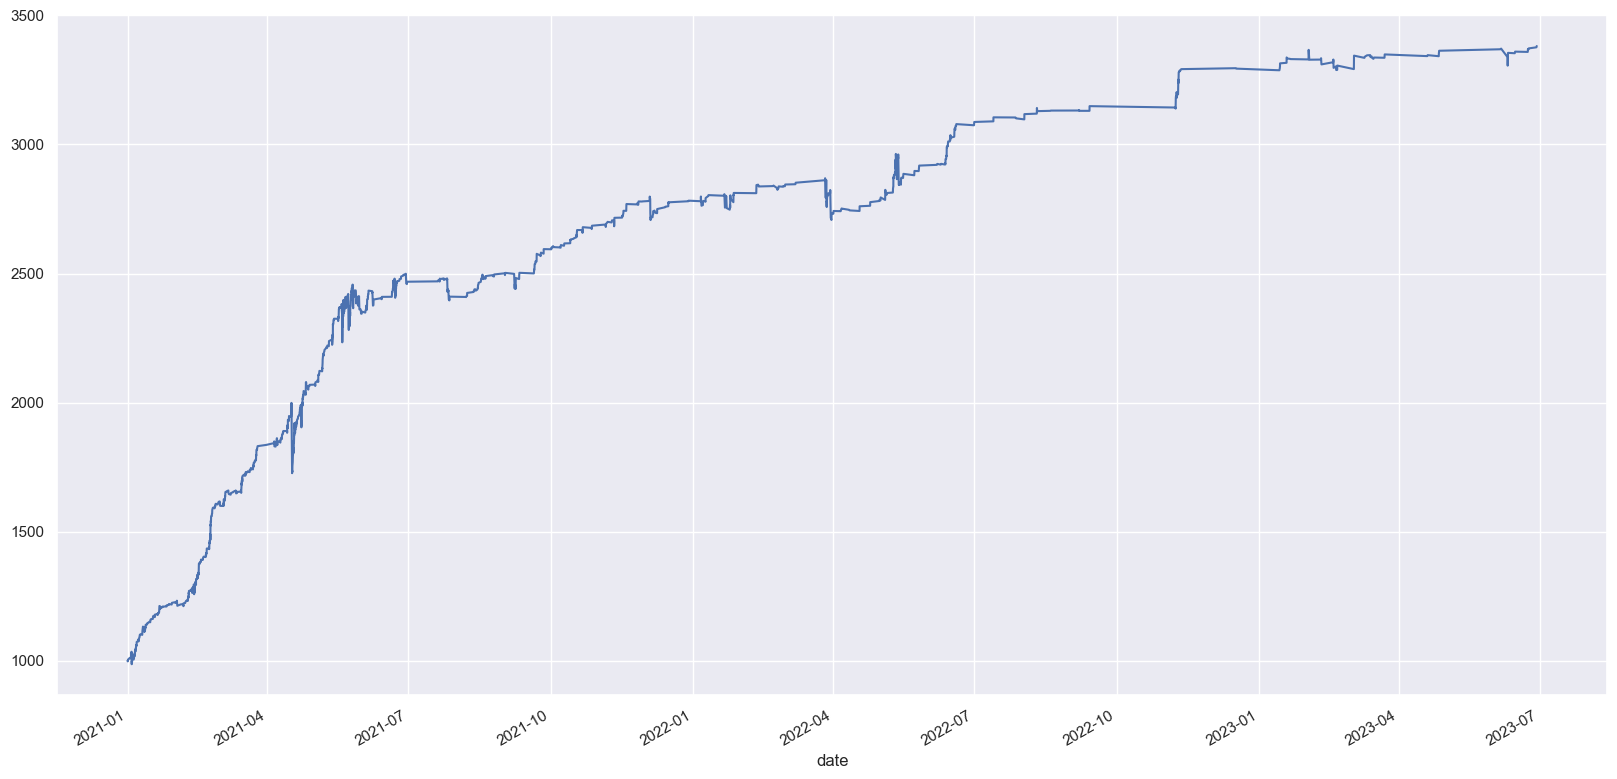

In [36]:
#BTobject.plot_wallet_evolution(dfTrades=newDf['2018'])
#BTobject.plot_wallet_evolution(dfTrades=newDf['2019'])
BTobject.plot_wallet_evolution(dfTrades)


----- Plot -----


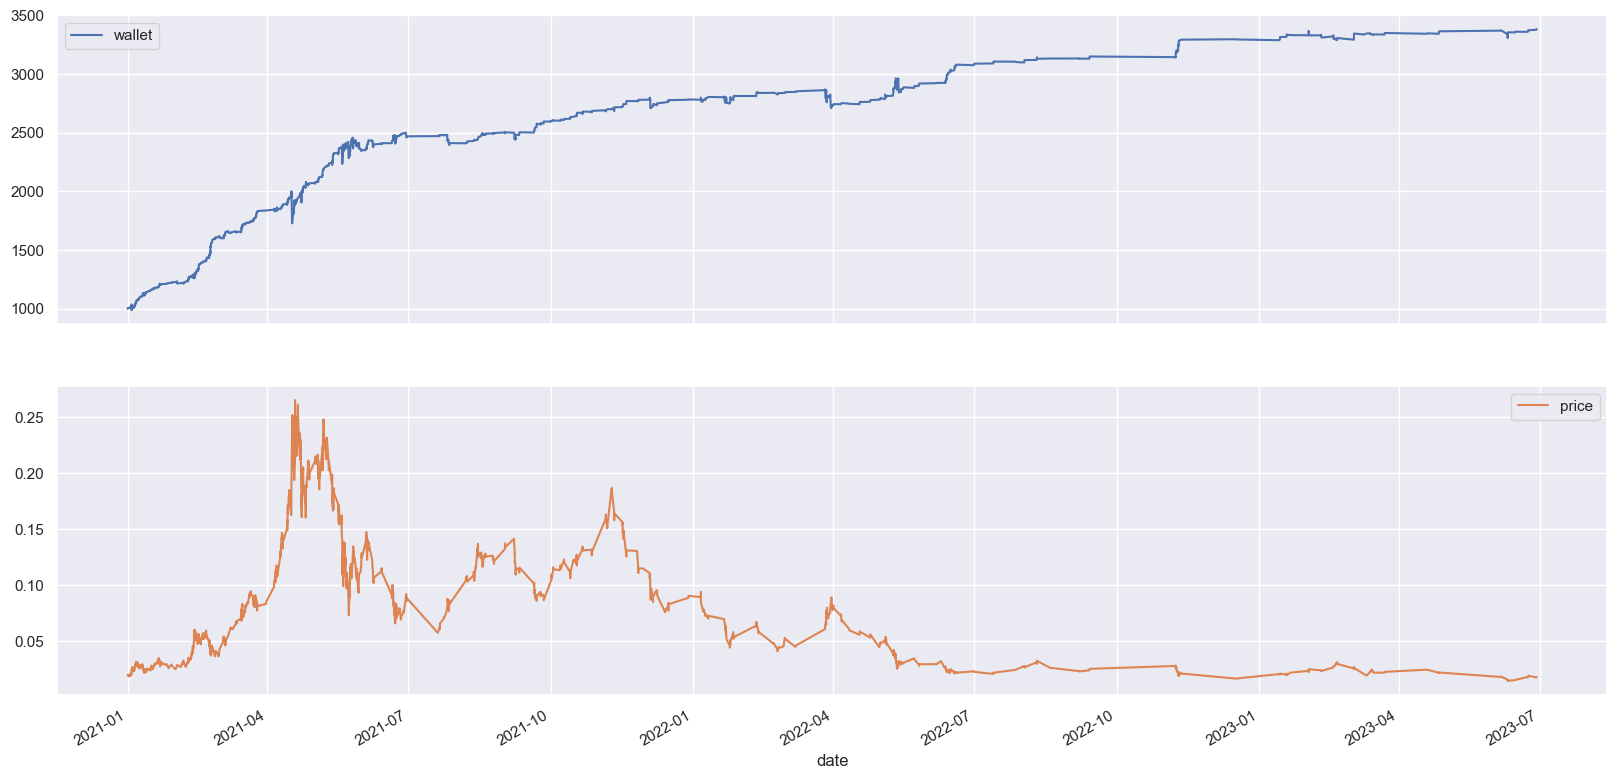

In [37]:
BTobject.plot_wallet_vs_price(dfTrades)

In [38]:
BTobject.get_result_by_month(dfTrades)

2021 1 22.38 %
2021 2 31.99 %
2021 3 13.61 %
2021 4 12.24 %
2021 5 13.27 %
2021 6 5.28 %
2021 7 -2.4 %
2021 8 3.62 %
2021 9 3.74 %
2021 10 3.52 %
2021 11 3.33 %
2021 12 0.04 %
2022 1 1.16 %
2022 2 0.99 %
2022 3 -3.66 %
2022 4 1.79 %
2022 5 4.75 %
2022 6 5.4 %
2022 7 0.87 %
2022 8 1.1 %
2022 9 0.54 %
2022 10 0 %
2022 11 4.73 %
2022 12 -0.05 %
2023 1 1.32 %
2023 2 -0.72 %
2023 3 1.73 %
2023 4 0.62 %
2023 5 0 %
2023 6 0.37 %
